### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
#Hay tweets repetidos, eliminar?
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
id          7434 non-null int64
keyword     7378 non-null object
location    4982 non-null object
text        7434 non-null object
target      7434 non-null int64
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


#### Top ciudades mentirosas/dicen la verdad #### 

In [8]:
#No me importan las locaciones NAN
partial = tweets.dropna()

In [9]:
#10 lugares con mas tweets
top_10_locations = partial['location'].value_counts().nlargest(10).to_frame()
top_10_locations

,location
USA,104
New York,71
United States,50
London,45
Canada,29
UK,26
"Los Angeles, CA",26
Nigeria,22
"Washington, DC",21
Mumbai,20


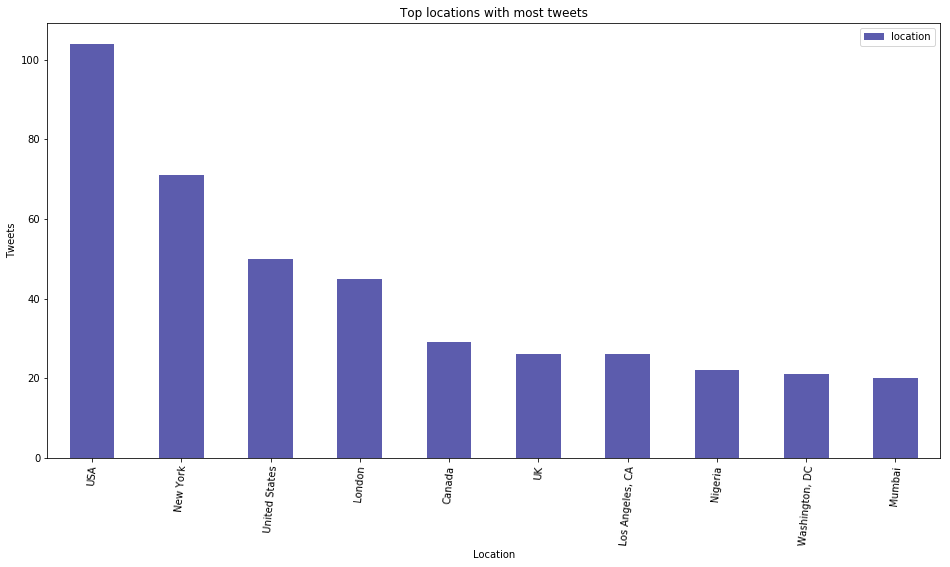

In [10]:
top_10_locations.plot(kind='bar',  rot=85, title='Top locations with most tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [11]:
by_location = partial.groupby(['location']).agg({'target':['count', 'sum']})

In [12]:
by_location.head()

target    
                        count sum
location                         
                            1   1
  Glasgow                   1   0
  Melbourne, Australia      1   0
  News                      1   1
  å_                        1   0

In [13]:
level_0 = by_location.columns.get_level_values(0)
level_1 = by_location.columns.get_level_values(1)
by_location.columns = level_0 + '_' + level_1
by_location.reset_index(inplace=True)
by_location.head()

,location,target_count,target_sum
0,,1,1
1,Glasgow,1,0
2,"Melbourne, Australia",1,0
3,News,1,1
4,å_,1,0


In [14]:
by_location['fake_sum'] = by_location['target_count'] - by_location['target_sum']
by_location.head()

,location,target_count,target_sum,fake_sum
0,,1,1,0
1,Glasgow,1,0,1
2,"Melbourne, Australia",1,0,1
3,News,1,1,0
4,å_,1,0,1


In [15]:
by_location.describe()

,target_count,target_sum,fake_sum
count,3303.000000,3303.000000,3303.000000
mean,1.508326,0.644263,0.864063
std,3.002196,1.711384,1.691175
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000
max,104.000000,67.000000,55.000000


In [16]:
#Coordenadas
by_location.loc[by_location.location.str.contains('ÌÏT'), :]

,location,target_count,target_sum,fake_sum
1507,"London/Lagos/FL ÌÏT: 6.6200132,",1,1,0
3279,"ÌÏT: -26.695807,27.837865",1,0,1
3280,"ÌÏT: 0.0,0.0",1,0,1
3281,"ÌÏT: 1.50225,103.742992",1,1,0
3282,"ÌÏT: 10.614817868480726,12.195582811791382",2,2,0
3283,"ÌÏT: 19.123127,72.825133",1,0,1
3284,"ÌÏT: 27.9136024,-81.6078532",1,0,1
3285,"ÌÏT: 30.307558,-81.403118",1,0,1
3286,"ÌÏT: 33.209923,-87.545328",1,0,1
3287,"ÌÏT: 35.223347,-80.827834",1,0,1


In [17]:
#Ejemplo de caracteres random åø\_(?)_/åø	
by_location.loc[by_location.location.str.contains("å"), :]

,location,target_count,target_sum,fake_sum
4,å_,1,0,1
5,45å¡ 5'12.53N 14å¡ 7'24.93E,1,0,1
7,? ??????? ? ( ?? å¡ ? ? ? å¡),1,1,0
70,"( ?å¡ ?? ?å¡),",1,0,1
130,518 åá NY,1,0,1
158,?? ?+254? ? \??å¡_??å¡_???å¡_?/??,1,1,0
190,?^åá??åá?^?? ??,1,0,1
1513,Long Eaton åá Derbyshire åá UK,1,0,1
2010,Pekanbaruå¡Batam Islandå¡Medan,1,0,1
3273,Û¢5Û¢12Û¢14Û¢ | åÈ#SaviourSquadåÇ,1,0,1


In [18]:
#10 ciudades que mas reales tienen
most_real = by_location.nlargest(15, 'target_sum').loc[:,['location', 'target_sum']].set_index('location')
most_real

,target_sum
location,
USA,67
United States,27
Mumbai,18
India,17
London,16
New York,16
Nigeria,16
UK,15
"Washington, DC",15


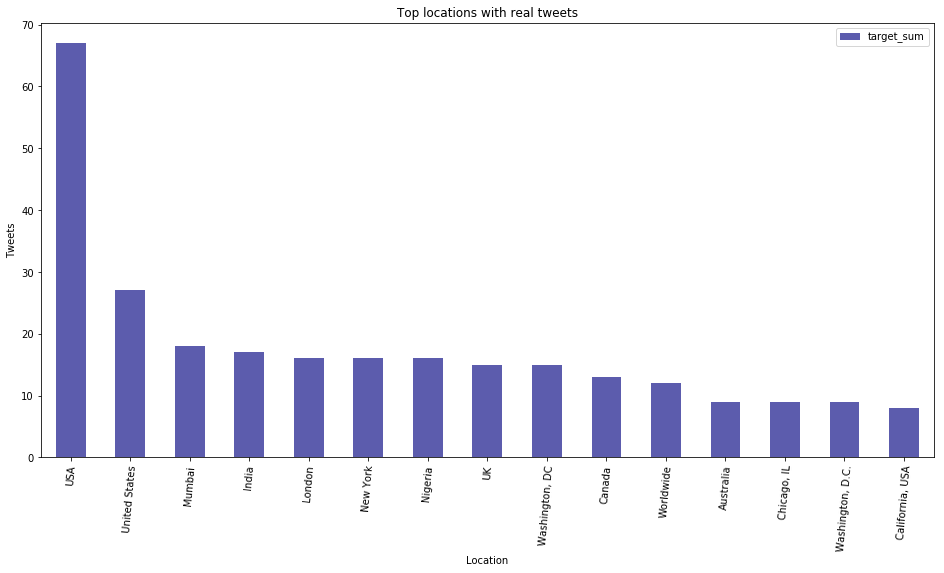

In [19]:
most_real.plot(kind='bar',  rot=85, title='Top locations with real tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [20]:
#10 ciudades que mas falsos tienen
most_fake = by_location.nlargest(15, 'fake_sum').loc[:,['location', 'fake_sum']].set_index('location')
most_fake

,fake_sum
location,
New York,55
USA,37
London,29
United States,23
"Los Angeles, CA",18
Canada,16
Kenya,15
Everywhere,12
Florida,11


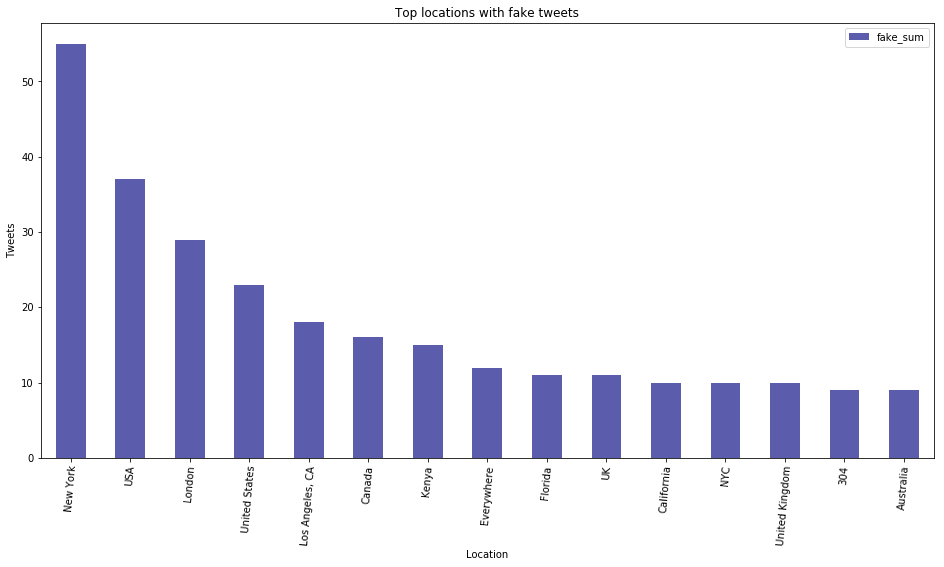

In [21]:
most_fake.plot(kind='bar',  rot=85, title='Top locations with fake tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [22]:
by_location['target_count'].value_counts()

1      2801
2       255
3        94
4        48
5        33
6        15
7         8
9         7
10        6
11        5
8         4
14        3
20        3
13        3
15        3
18        2
12        2
26        2
29        1
104       1
22        1
50        1
21        1
45        1
17        1
19        1
71        1
Name: target_count, dtype: int64

In [23]:
mean_fake_tweets = by_location['fake_sum'].mean()
mean_real_tweets = by_location['target_sum'].mean()

In [24]:
mean_fake_tweets

0.86406297305479862

In [25]:
mean_real_tweets

0.64426279140175602

Palabras y expresiones mas usadas en tweets, no importa real or fake.

In [26]:
tweets[tweets['text'].str.contains('cool')]

,id,keyword,location,text,target
21,32,NaN,NaN,London is cool ;),0
625,899,bioterrorism,NaN,CDC has a pretty cool list of all bioterrorism...,1
751,1083,blew%20up,Indiana,My Instagram just blew up apparently I was fea...,0
812,1179,blizzard,NaN,What if every 5000 wins in ranked play gave yo...,0
1283,1851,burned,"Escondido, CA",I just remembered the McDonald's that burned d...,0
1333,1925,burning%20buildings,please H? ?:??,the mv should just be them strutting like they...,1
1442,2078,casualty,"Trinity, Bailiwick of Jersey",@ScriptetteSar @katiecool447 btw the 30th is a...,1
1471,2119,catastrophe,"los angeles, ca",Then the stylist who'd been silent says 'there...,0
1597,2306,collapse,"Highland Park, CA",Time collapse is such a cool video technique. ...,0
1659,2396,collapsed,wherever-the-fuck washington,@flickershowell oh wow my heart collapsed cool...,1


Personas mas mencionadas

Podria filtrarse por real y fake

In [27]:
tweets_with_mentions = tweets[tweets['text'].str.contains('@')]
mentions = tweets_with_mentions['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
#La regex encuentra todas las palabras que empiecen con '@' y al mismo tiempo elimina los '@:' y '@ '

In [28]:
mentions.head()

,text
31,[@bbcmtd]
36,[@PhDSquares]
43,[@southridgelife]
54,[@Alexis_Sanchez]
57,[@Û_]


In [29]:
#El arroba se usa como expresion para indicar la hora tambien

In [30]:
mentions_to_group = mentions.explode('text')

In [31]:
mentions_to_group.head()

,text
31,@bbcmtd
36,@PhDSquares
43,@southridgelife
54,@Alexis_Sanchez
57,@Û_


In [32]:
mentions_grouped = mentions_to_group.groupby('text').agg({'text': 'count'}).nlargest(20, 'text')
mentions_grouped.columns = ['count']

In [33]:
mentions_grouped

,count
text,
@YouTube,82
@ArianaGrande,11
@Change,9
@FoxNews,9
@POTUS,9
@emmerdale,8
@justinbieber,7
@MikeParrActor,6
@Stretcher,6


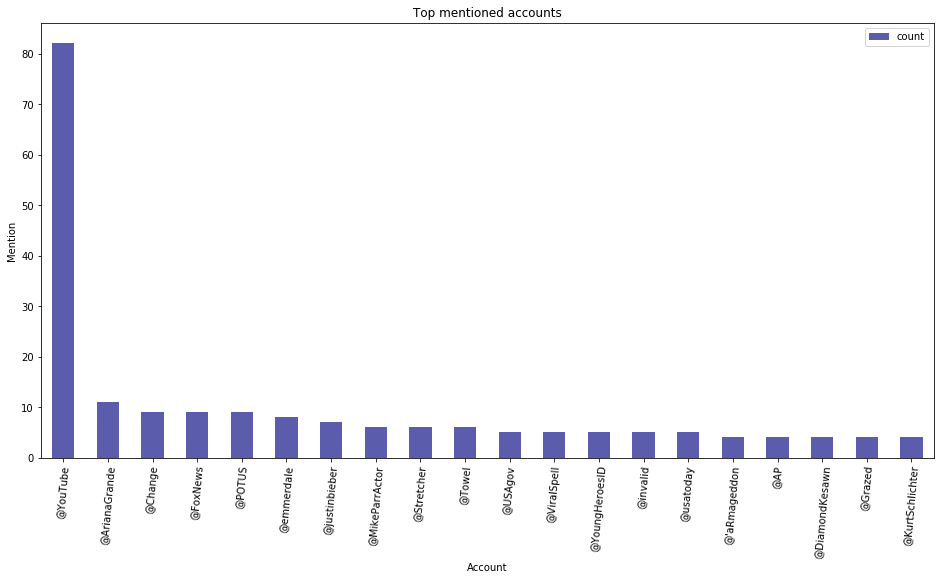

In [34]:
mentions_grouped.plot(kind='bar',  rot=85, title='Top mentioned accounts', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Mention')
ax.set_xlabel('Account')